This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/tree/main/wallaroo-features/model_insights).

The Model Insights feature lets you monitor how the environment that your model operates within may be changing in ways that affect it's predictions so that you can intervene (retrain) in an efficient and timely manner. Changes in the inputs, **data drift**, can occur due to errors in the data processing pipeline or due to changes in the environment such as user preference or behavior. 

The [validation framework](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipeline/#anomaly-testing) performs per inference range checks with count frequency based thresholds for alerts and is ideal for catching many errors in input and output data.

In complement to the validation framework model insights focuses on the differences in the distributions of data in a time based window measured against a baseline for a given pipeline and can detect situations where values are still within the expected range but the distribution has shifted. For example, if your model predicts housing prices you might expect the predictions to be between \\$200,000 and \\$1,000,000 with a distribution centered around \\$400,000. If your model suddenly starts predicting prices centered around \\$250,000 or \\$750,000 the predictions may still be within the expected range but the shift may signal something has changed that should be investigated.

Ideally we'd also monitor the _quality_ of the predictions, **concept drift**. However this can be difficult as true labels are often not available or are severely delayed in practice. That is there may be a signficant lag between the time the prediction is made and the true (sale price) value is observed.

Consequently, model insights uses data drift detection techniques on both inputs and outputs to detect changes in the distributions of the data.

There are many useful statistical tests for calculating the difference between distributions; however, they typically require assumptions about the underlying distributions or confusing and expensive calculations. We've implemented a data drift framework that is easy to understand, fast to compute, runs in an automated fashion and is extensible to many specific use cases.

The methodology currently revolves around calculating the specific percentile-based bins of the baseline distribution and measuring how future distributions fall into these bins. This approach is both visually intuitive and supports an easy to calculate difference score between distributions. Users can tune the scoring mechanism to emphasize different regions of the distribution: for example, you may only care if there is a change in the top 20th percentile of the distribution, compared to the baseline.

You can specify the inputs or outputs that you want to monitor and the data to use for your baselines. You can also specify how often you want to monitor distributions and set parameters to define what constitutes a meaningful change in a distribution for your application. 

Once you've set up a monitoring task, called an assay, comparisons against your baseline are then run automatically on a scheduled basis. You can be notified if the system notices any abnormally different behavior. The framework also allows you to quickly investigate the cause of any unexpected drifts in your predictions.

The rest of this notebook will shows how to create assays to monitor your pipelines.

**NOTE:** model insights operates over time and is difficult to demo in a notebook without pre-canned data. **We assume you have an active pipeline that has been running and making predictions over time and show you the code you may use to analyze your pipeline.**

## Prerequisites

* A deployed Wallaroo instance
* The following Python libraries installed:
  * `os`
  * `datetime`
  * `json`
  * `string`
  * `random`
  * [`numpy`](https://pypi.org/project/numpy/)
  * [`matplotlib`](https://pypi.org/project/matplotlib/)
  * [`wallaroo`](https://pypi.org/project/wallaroo/): The Wallaroo SDK. Included with the Wallaroo JupyterHub service by default.
  * [`pandas`](https://pypi.org/project/pandas/): Pandas, mainly used for Pandas DataFrame.
  * [`pyarrow`](https://pypi.org/project/pyarrow/): PyArrow for Apache Arrow support.


### Workflow

Model Insights has the capability to perform interactive assays so that you can explore the data from a pipeline and learn how the data is behaving. With this information and the knowledge of your particular business use case you can then choose appropriate thresholds for persistent automatic assays as desired.

To get started lets import some libraries we'll need.

In [5]:
import datetime as dt
from datetime import datetime, timedelta, timezone, tzinfo
import wallaroo
from wallaroo.object import EntityNotFoundError

import wallaroo.assay
from wallaroo.assay_config import BinMode, Aggregation, Metric

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
# For Wallaroo SDK 2023.1
os.environ["ARROW_ENABLED"]="True"

import json
from IPython.display import display

# used to display dataframe information without truncating
from IPython.display import display
pd.set_option('display.max_colwidth', None)

plt.rcParams["figure.figsize"] = (12,6)
pd.options.display.float_format = '{:,.2f}'.format

# ignoring warnings for demonstration
import warnings
warnings.filterwarnings('ignore')

In [6]:
wallaroo.__version__

'2023.2.0+9c25fa2d2'

### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  If logging in externally, update the `wallarooPrefix` and `wallarooSuffix` variables with the proper DNS information.  For more information on Wallaroo DNS settings, see the [Wallaroo DNS Integration Guide](https://docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-configuration/wallaroo-dns-guide/).

In [7]:
# Client connection from local Wallaroo instance

wl = wallaroo.Client()

### Connect to Workspace and Pipeline

We will now connect to the existing workspace and pipeline.  Update the variables below to match the ones used for past inferences.

In [8]:
workspace_name = 'housepricedrift'
pipeline_name = 'housepricepipe'
model_name = 'housepricemodel'

# Used to generate a unique assay name for each run

import string
import random
# make a random 4 character prefix
prefix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))

assay_name = f"{prefix}example assay"

In [9]:
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

def get_pipeline(name):
    try:
        pipeline = wl.pipelines_by_name(name)[0]
    except EntityNotFoundError:
        pipeline = wl.build_pipeline(name)
    return pipeline

In [10]:
workspace = get_workspace(workspace_name)

wl.set_current_workspace(workspace)

pipeline = get_pipeline(pipeline_name)
pipeline

name,housepricepipe
created,2023-04-24 15:06:23.573263+00:00
last_updated,2023-04-24 15:06:26.154044+00:00
deployed,False
tags,
versions,"9ca99bf5-946b-44cf-ba41-4a6bd2301489, f3480c89-dac5-4422-a936-ace719841ab7"
steps,housepricemodel


We assume the pipeline has been running for a while and there is a period of time that is free of errors that we'd like to use as the _baseline_. Lets note the start and end times. For this example we have 30 days of data from Jan 2023 and well use Jan 1 data as our baseline.

In [11]:
import datetime
baseline_start = datetime.datetime.fromisoformat('2023-01-01T00:00:00+00:00')
baseline_end = datetime.datetime.fromisoformat('2023-01-02T00:00:00+00:00')
last_day = datetime.datetime.fromisoformat('2023-02-01T00:00:00+00:00')

Lets create an assay using that pipeline and the model in the pipeline. We also specify the start end end of the baseline.

It is highly recommended when creating assays to set the input/output path with the `add_iopath` method.  This specifies:

* Whether to track the input or output variables of an inference.
* The name of the field to track.
* The index of the field.

In our example, that is `output dense_2 0` for "track the outputs, by the field `dense_2`, and the index of `dense_2` at 0.

In [12]:
assay_builder = wl.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end).add_iopath("output dense_2 0")

We don't know much about our baseline data yet so lets examine the data and create a couple of visual representations. First lets get some basic stats on the baseline data.

In [13]:
baseline_run = assay_builder.build().interactive_baseline_run()
baseline_run.baseline_stats()

,Baseline
count,182
min,12.00
max,14.97
mean,12.94
median,12.88
std,0.45
start,2023-01-01T00:00:00Z
end,2023-01-02T00:00:00Z


Another option is the `baseline_dataframe` method to retrieve the baseline data with each field as a DataFrame column.  To cut down on space, we'll display just the `output_dense_2_0` column, which corresponds to the `output output_dense 2` iopath set earlier.

In [50]:
assay_dataframe = assay_builder.baseline_dataframe()
display(assay_dataframe.loc[:, ["time", "metadata", "output_dense_2_0"]])

,time,metadata,output_dense_2_0
0,1672531200000,"{'last_model': '{""model_name"": ""housepricemodel"", ""model_sha"": ""test_version""}', 'profile': '{""elapsed_ns"": 233}'}",12.53
1,1672531676753,"{'last_model': '{""model_name"": ""housepricemodel"", ""model_sha"": ""test_version""}', 'profile': '{""elapsed_ns"": 269}'}",13.36
2,1672532153506,"{'last_model': '{""model_name"": ""housepricemodel"", ""model_sha"": ""test_version""}', 'profile': '{""elapsed_ns"": 104}'}",12.80
3,1672532630259,"{'last_model': '{""model_name"": ""housepricemodel"", ""model_sha"": ""test_version""}', 'profile': '{""elapsed_ns"": 113}'}",12.79
4,1672533107013,"{'last_model': '{""model_name"": ""housepricemodel"", ""model_sha"": ""test_version""}', 'profile': '{""elapsed_ns"": 65}'}",13.16
...,...,...,...
177,1672615585332,"{'last_model': '{""model_name"": ""housepricemodel"", ""model_sha"": ""test_version""}', 'profile': '{""elapsed_ns"": 257}'}",12.37
178,1672616062086,"{'last_model': '{""model_name"": ""housepricemodel"", ""model_sha"": ""test_version""}', 'profile': '{""elapsed_ns"": 250}'}",12.96
179,1672616538839,"{'last_model': '{""model_name"": ""housepricemodel"", ""model_sha"": ""test_version""}', 'profile': '{""elapsed_ns"": 317}'}",12.37
180,1672617015592,"{'last_model': '{""model_name"": ""housepricemodel"", ""model_sha"": ""test_version""}', 'profile': '{""elapsed_ns"": 109}'}",12.61


Now lets look at a histogram, kernel density estimate (KDE), and Emperical Cumulative Distribution (ecdf) charts of the baseline data. These will give us insite into the distributions of the predictions and features that the assay is configured for.

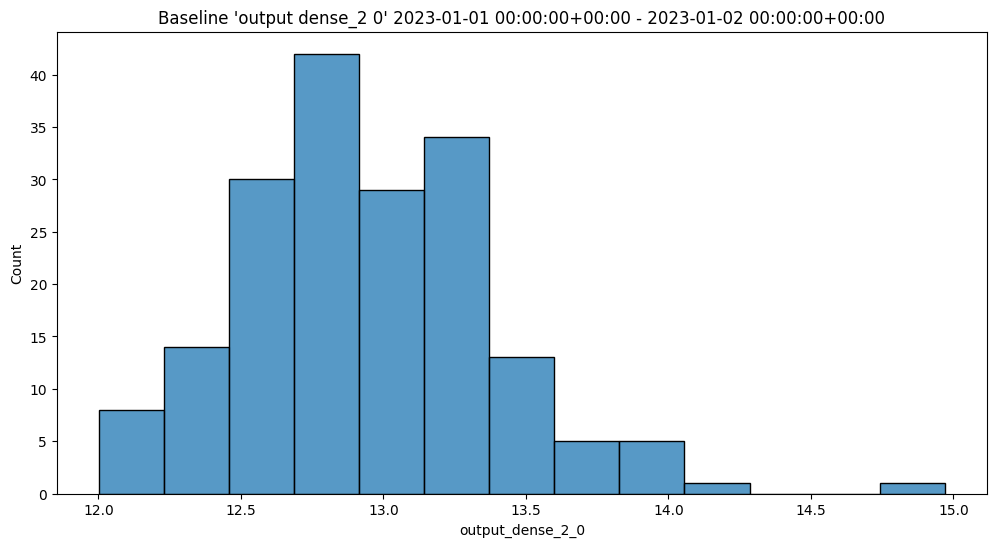

In [15]:
assay_builder.baseline_histogram()

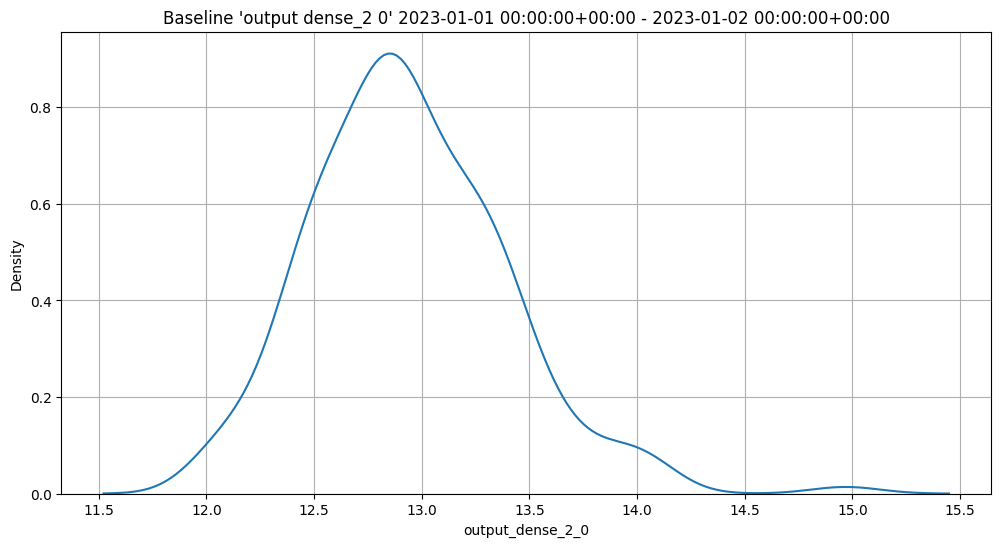

In [16]:
assay_builder.baseline_kde()

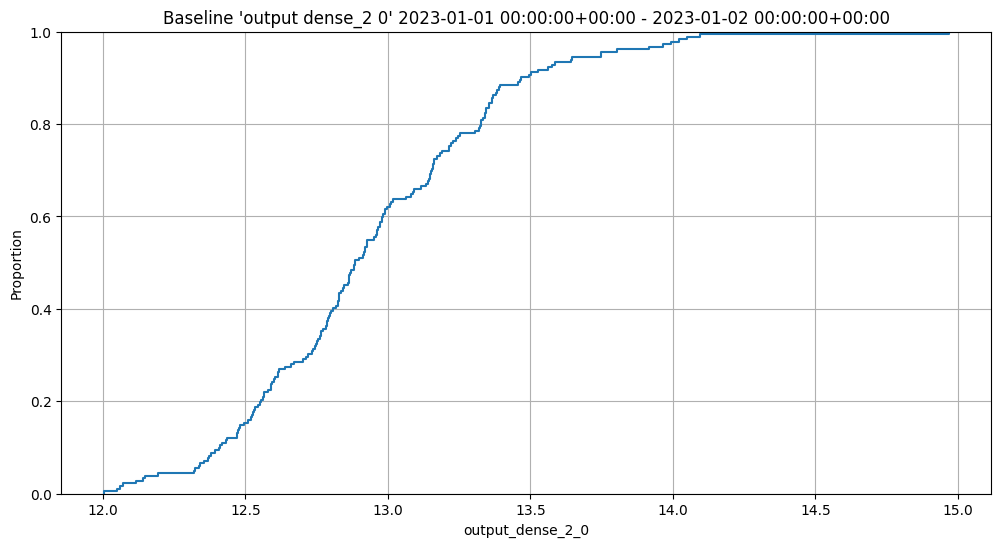

In [17]:
assay_builder.baseline_ecdf()

## List Assays

Assays are listed through the Wallaroo Client `list_assays` method. 

In [18]:
wl.list_assays()

name,active,status,warning_threshold,alert_threshold,pipeline_name
hpofexample assay,True,created,None,0.5,housepricepipe
dtxjexample assay,True,created,None,0.5,housepricepipe
test,True,"{""run_at"": ""2023-04-24T15:21:05.155113101+00:00"", ""num_ok"": 12, ""num_warnings"": 0, ""num_alerts"": 5}",None,0.1,housepricepipe


### Interactive Baseline Runs
We can do an interactive run of just the baseline part to see how the baseline data will be put into bins. This assay uses quintiles so all 5 bins (not counting the outlier bins) have 20% of the predictions. We can see the bin boundaries along the x-axis.

baseline mean = 12.940910643273655
baseline median = 12.884286880493164
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False


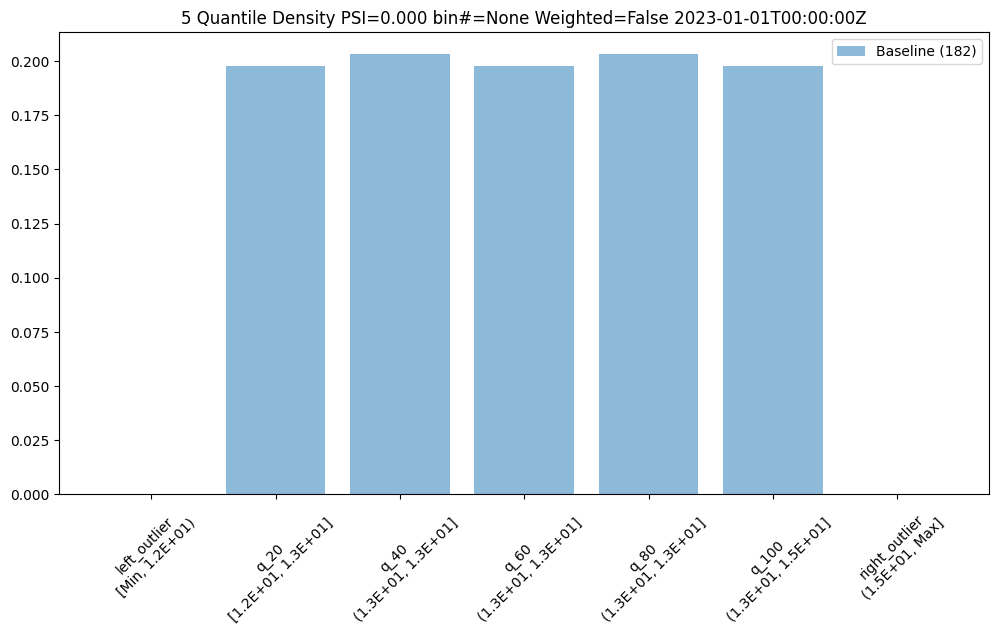

In [19]:
baseline_run.chart()

We can also get a dataframe with the bin/edge information.

In [20]:
baseline_run.baseline_bins()

,b_edges,b_edge_names,b_aggregated_values,b_aggregation
0,12.00,left_outlier,0.00,Density
1,12.55,q_20,0.20,Density
2,12.81,q_40,0.20,Density
3,12.98,q_60,0.20,Density
4,13.33,q_80,0.20,Density
5,14.97,q_100,0.20,Density
6,inf,right_outlier,0.00,Density


The previous assay used quintiles so all of the bins had the same percentage/count of samples.  To get bins that are divided equaly along the range of values we can use `BinMode.EQUAL`.

baseline mean = 12.940910643273655
baseline median = 12.884286880493164
bin_mode = Equal
aggregation = Density
metric = PSI
weighted = False


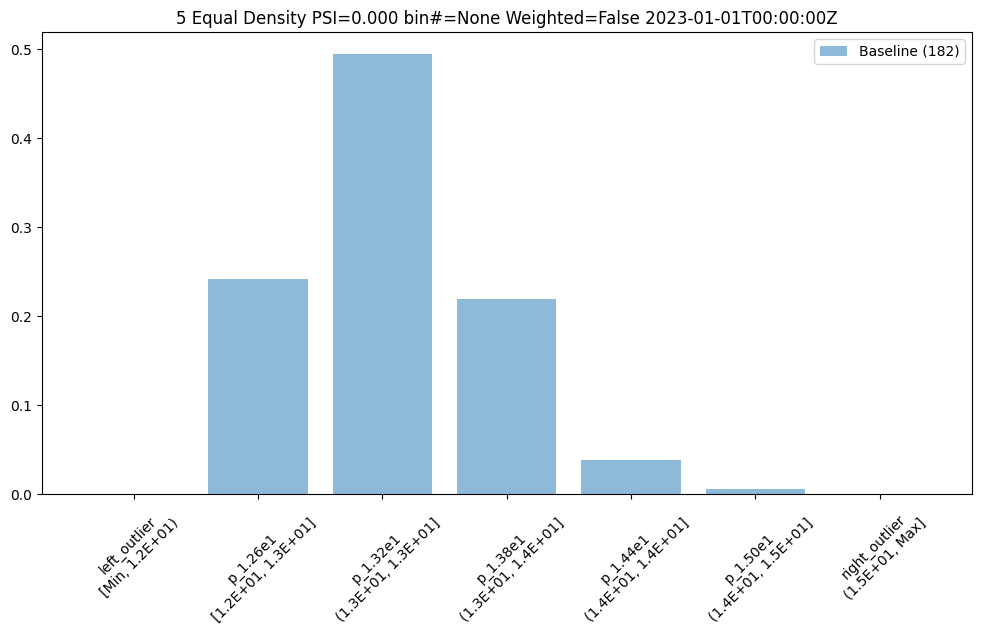

In [21]:
equal_bin_builder = wl.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end)
equal_bin_builder.summarizer_builder.add_bin_mode(BinMode.EQUAL)
equal_baseline = equal_bin_builder.build().interactive_baseline_run()
equal_baseline.chart()

We now see very different bin edges and sample percentages per bin.

In [22]:
equal_baseline.baseline_bins()

,b_edges,b_edge_names,b_aggregated_values,b_aggregation
0,12.00,left_outlier,0.00,Density
1,12.60,p_1.26e1,0.24,Density
2,13.19,p_1.32e1,0.49,Density
3,13.78,p_1.38e1,0.22,Density
4,14.38,p_1.44e1,0.04,Density
5,14.97,p_1.50e1,0.01,Density
6,inf,right_outlier,0.00,Density


### Interactive Assay Runs
By default the assay builder creates an assay with some good starting parameters. In particular the assay is configured to run a new analysis for every 24 hours starting at the end of the baseline period. Additionally, it sets the number of bins to 5 so creates quintiles, and sets the target `iopath` to `"outputs 0 0"` which means we want to monitor the first column of the first output/prediction.

We can do an interactive run of just the baseline part to see how the baseline data will be put into bins. This assay uses quintiles so all 5 bins (not counting the outlier bins) have 20% of the predictions. We can see the bin boundaries along the x-axis.

We then run it with `interactive_run` and convert it to a dataframe for easy analysis with `to_dataframe`.

Now lets do an interactive run of the first assay as it is configured.  Interactive runs don't save the assay to the database (so they won't be scheduled in the future) nor do they save the assay results. Instead the results are returned after a short while for further analysis.

In [23]:
assay_builder = wl.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end)
assay_config = assay_builder.add_run_until(last_day).build()
assay_results = assay_config.interactive_run()

In [24]:
assay_df = assay_results.to_dataframe()
assay_df.loc[:, ~assay_df.columns.isin(['assay_id', 'iopath', 'name', 'warning_threshold'])]

,score,start,min,max,mean,median,std,alert_threshold,status
0,0.00,2023-01-02T00:00:00+00:00,12.05,14.71,12.97,12.90,0.48,0.25,Ok
1,0.09,2023-01-03T00:00:00+00:00,12.04,14.65,12.96,12.93,0.41,0.25,Ok
2,0.04,2023-01-04T00:00:00+00:00,11.87,14.02,12.98,12.95,0.46,0.25,Ok
3,0.06,2023-01-05T00:00:00+00:00,11.92,14.46,12.93,12.87,0.46,0.25,Ok
4,0.02,2023-01-06T00:00:00+00:00,12.02,14.15,12.95,12.90,0.43,0.25,Ok
5,0.03,2023-01-07T00:00:00+00:00,12.18,14.58,12.96,12.93,0.44,0.25,Ok
6,0.02,2023-01-08T00:00:00+00:00,12.01,14.60,12.92,12.90,0.46,0.25,Ok
7,0.04,2023-01-09T00:00:00+00:00,12.01,14.40,13.00,12.97,0.45,0.25,Ok
8,0.06,2023-01-10T00:00:00+00:00,11.99,14.79,12.94,12.91,0.46,0.25,Ok
9,0.02,2023-01-11T00:00:00+00:00,11.90,14.66,12.91,12.88,0.45,0.25,Ok


Basic functionality for creating quick charts is included.

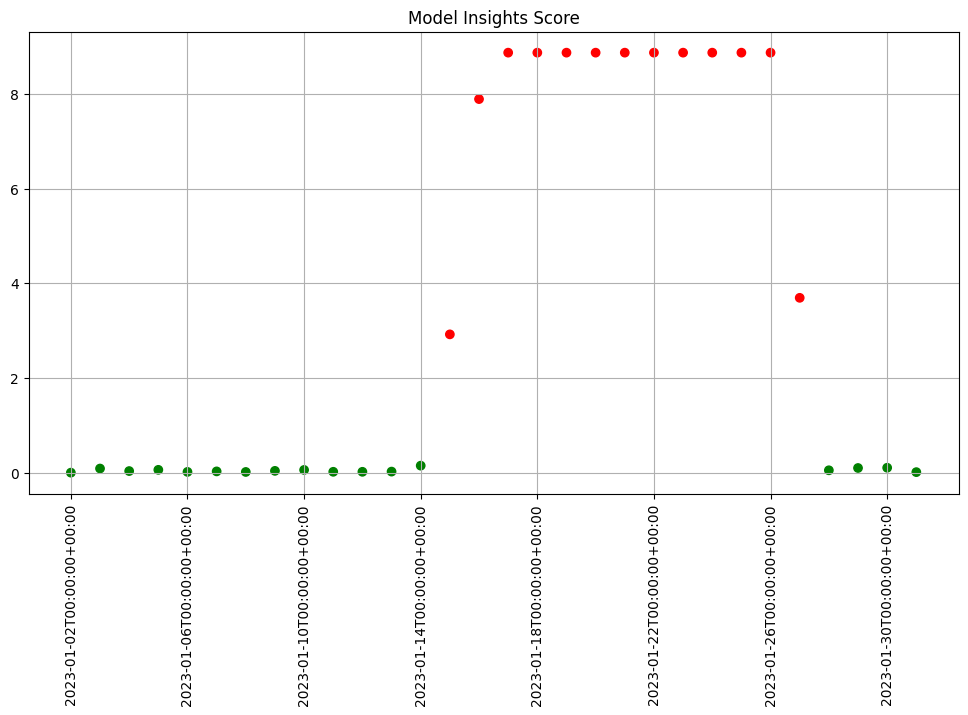

In [25]:
assay_results.chart_scores()

We see that the difference scores are low for a while and then jump up to indicate there is an issue. We can examine that particular window to help us decide if that threshold is set correctly or not.

We can generate a quick chart of the results. This chart shows the 5 quantile bins (quintiles) derived from the baseline data plus one for left outliers and one for right outliers.  We also see that the data from the window falls within the baseline quintiles but in a different proportion and is skewing higher. Whether this is an issue or not is specific to your use case.

First lets examine a day that is only slightly different than the baseline. We see that we do see some values that fall outside of the range from the baseline values, the left and right outliers, and that the bin values are different but similar.

baseline mean = 12.940910643273655
window mean = 12.969964654406132
baseline median = 12.884286880493164
window median = 12.899214744567873
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.0029273068646199748
scores = [0.0, 0.000514261205558409, 0.0002139202456922972, 0.0012617897456473992, 0.0002139202456922972, 0.0007234154220295724, 0.0]
index = None


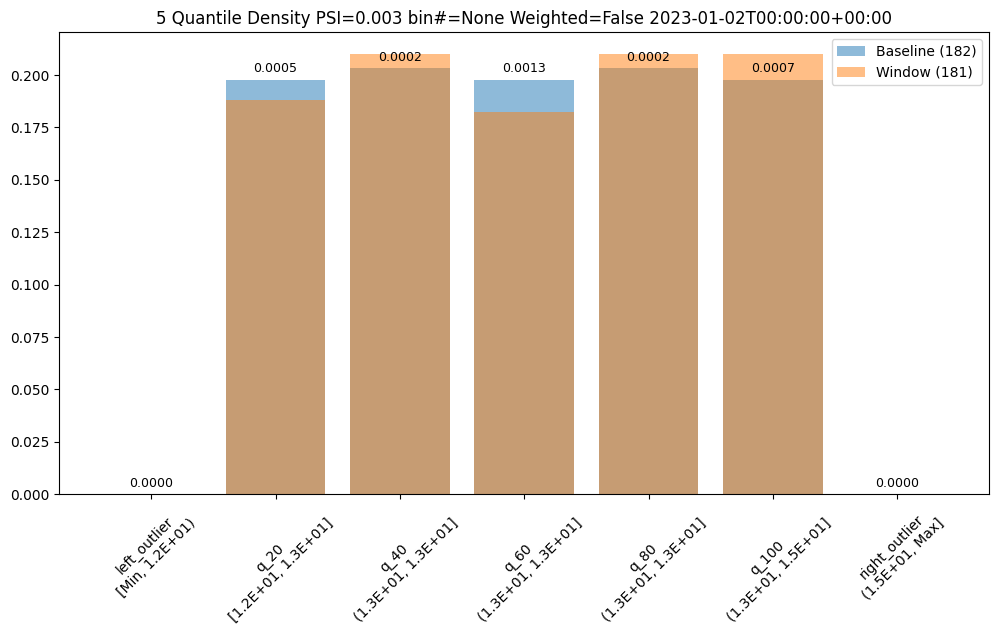

In [26]:
assay_results[0].chart()

Other days, however are significantly different.

baseline mean = 12.940910643273655
window mean = 13.06380216891949
baseline median = 12.884286880493164
window median = 13.027600288391112
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.15060511096978788
scores = [4.6637149189075455e-05, 0.05969428191167242, 0.00806617426854112, 0.008316273402678306, 0.07090885609902021, 0.003572888138686759, 0.0]
index = None


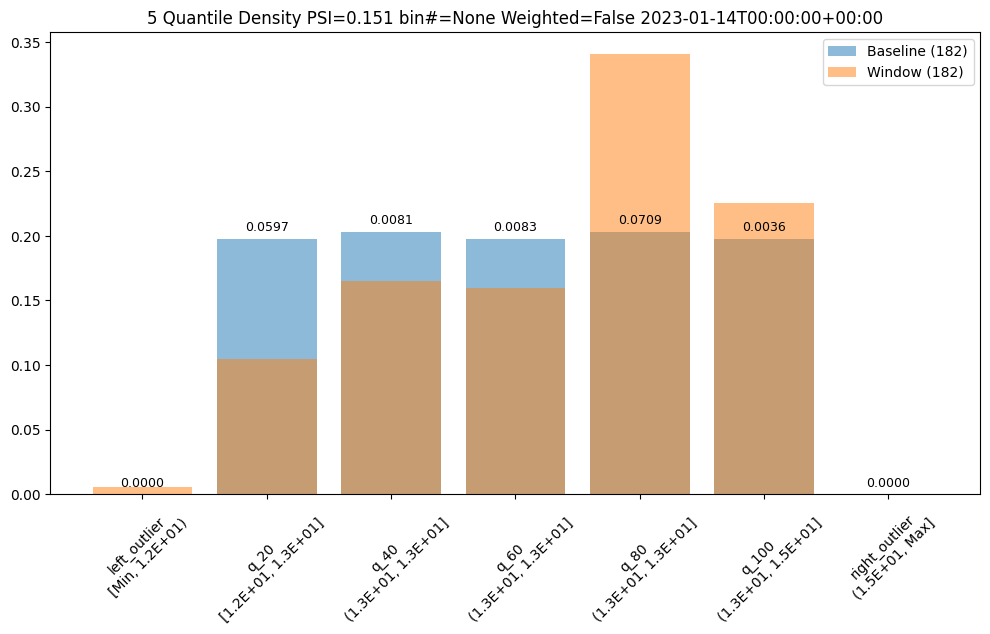

In [27]:
assay_results[12].chart()

baseline mean = 12.940910643273655
window mean = 14.004728427908038
baseline median = 12.884286880493164
window median = 14.009637832641602
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 2.9220486095961196
scores = [0.0, 0.7090936334784107, 0.7130482300184766, 0.33500731896676245, 0.12171058214520876, 0.9038825518183468, 0.1393062931689142]
index = None


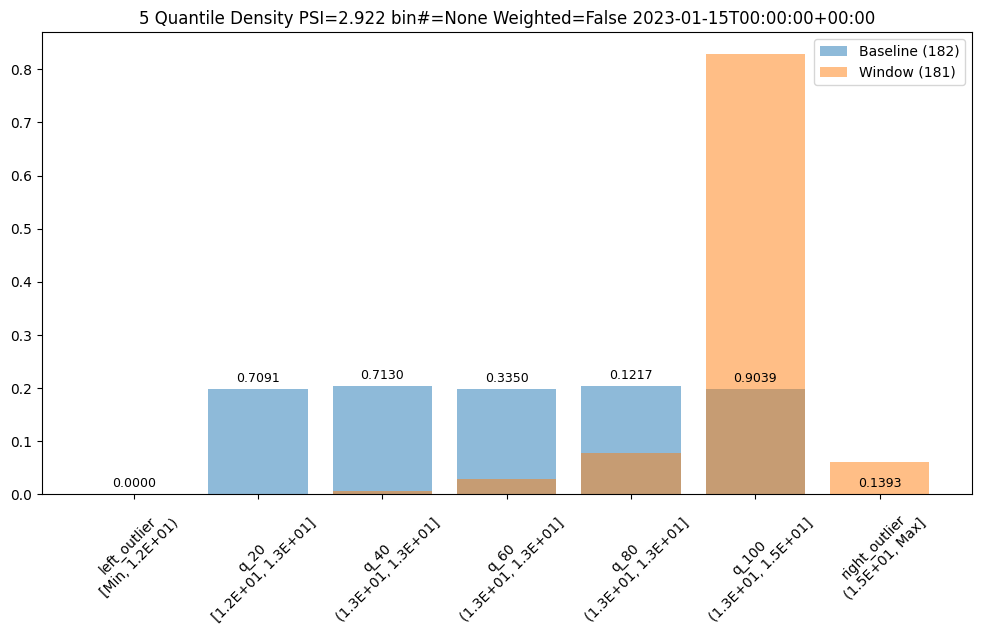

In [28]:
assay_results[13].chart()

If we want to investigate further, we can run interactive assays on each of the inputs to see if any of them show anything abnormal. In this example we'll provide the feature labels to create more understandable titles.

The current assay expects continuous data. Sometimes categorical data is encoded as 1 or 0 in a feature and sometimes in a limited number of values such as 1, 2, 3. If one value has high a percentage the analysis emits a warning so that we know the scores for that feature may not behave as we expect.

In [29]:
labels = ['bedrooms', 'bathrooms', 'lat', 'long', 'waterfront', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']

topic = wl.get_topic_name(pipeline.id())

all_inferences = wl.get_raw_pipeline_inference_logs(topic, baseline_start, last_day, model_name, limit=1_000_000)

assay_builder = wl.build_assay("Input Assay", pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_builder.window_builder().add_width(hours=4)
assay_config = assay_builder.build()
assay_results = assay_config.interactive_input_run(all_inferences, labels)
iadf = assay_results.to_dataframe()
display(iadf.loc[:, ~iadf.columns.isin(['assay_id', 'iopath', 'name', 'warning_threshold'])])

column distinct_vals label           largest_pct
     0            17 bedrooms        0.4244 
     1            44 bathrooms       0.2398 
     2          3281 lat             0.0014 
     3           959 long            0.0066 
     4             4 waterfront      0.9156 *** May not be continuous feature
     5          3901 sqft_living     0.0032 
     6          3487 sqft_lot        0.0173 
     7            11 floors          0.4567 
     8            10 view            0.8337 
     9             9 condition       0.5915 
    10            19 grade           0.3943 
    11           745 sqft_above      0.0096 
    12           309 sqft_basement   0.5582 
    13           224 yr_built        0.0239 
    14            77 yr_renovated    0.8889 
    15           649 sqft_living15   0.0093 
    16          3280 sqft_lot15      0.0199 


,score,start,min,max,mean,median,std,alert_threshold,status
0,0.19,2023-01-02T00:00:00+00:00,-2.54,1.75,0.21,0.68,0.99,0.25,Ok
1,0.03,2023-01-02T04:00:00+00:00,-1.47,2.82,0.21,-0.40,0.95,0.25,Ok
2,0.09,2023-01-02T08:00:00+00:00,-2.54,3.89,-0.04,-0.40,1.22,0.25,Ok
3,0.05,2023-01-02T12:00:00+00:00,-1.47,2.82,-0.12,-0.40,0.94,0.25,Ok
4,0.08,2023-01-02T16:00:00+00:00,-1.47,1.75,-0.00,-0.40,0.76,0.25,Ok
...,...,...,...,...,...,...,...,...,...
3055,0.08,2023-01-31T04:00:00+00:00,-0.42,4.87,0.25,-0.17,1.13,0.25,Ok
3056,0.58,2023-01-31T08:00:00+00:00,-0.43,2.01,-0.04,-0.21,0.48,0.25,Alert
3057,0.13,2023-01-31T12:00:00+00:00,-0.32,7.75,0.30,-0.20,1.57,0.25,Ok
3058,0.26,2023-01-31T16:00:00+00:00,-0.43,5.88,0.19,-0.18,1.17,0.25,Alert


We can chart each of the iopaths and do a visual inspection. From the charts we see that if any of the input features had significant differences in the first two days which we can choose to inspect further. Here we choose to show 3 charts just to save space in this notebook.

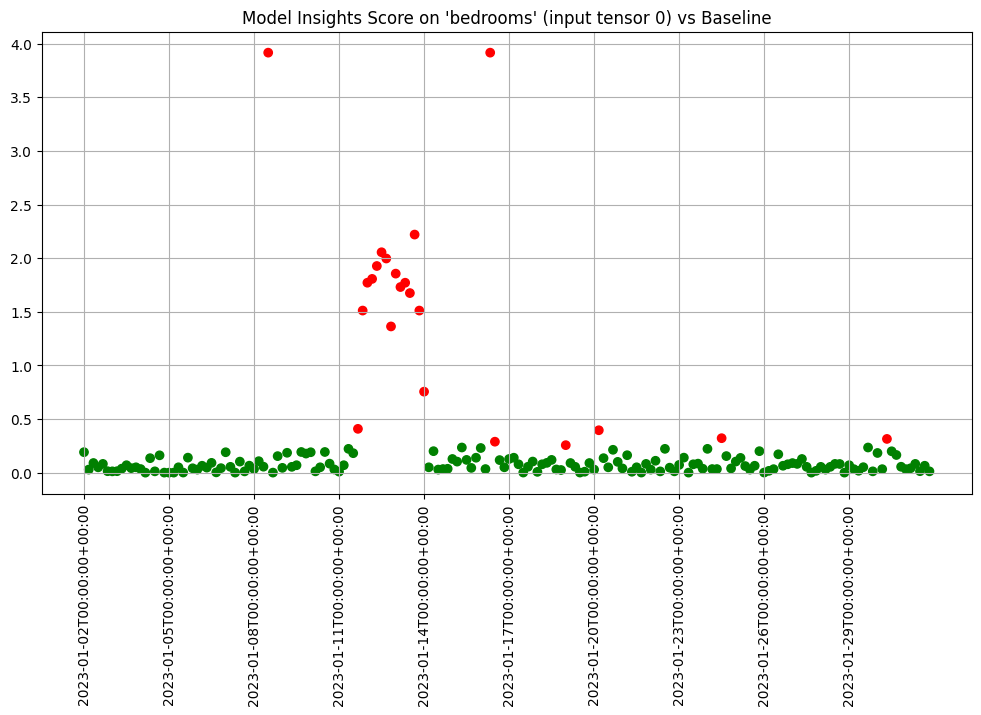

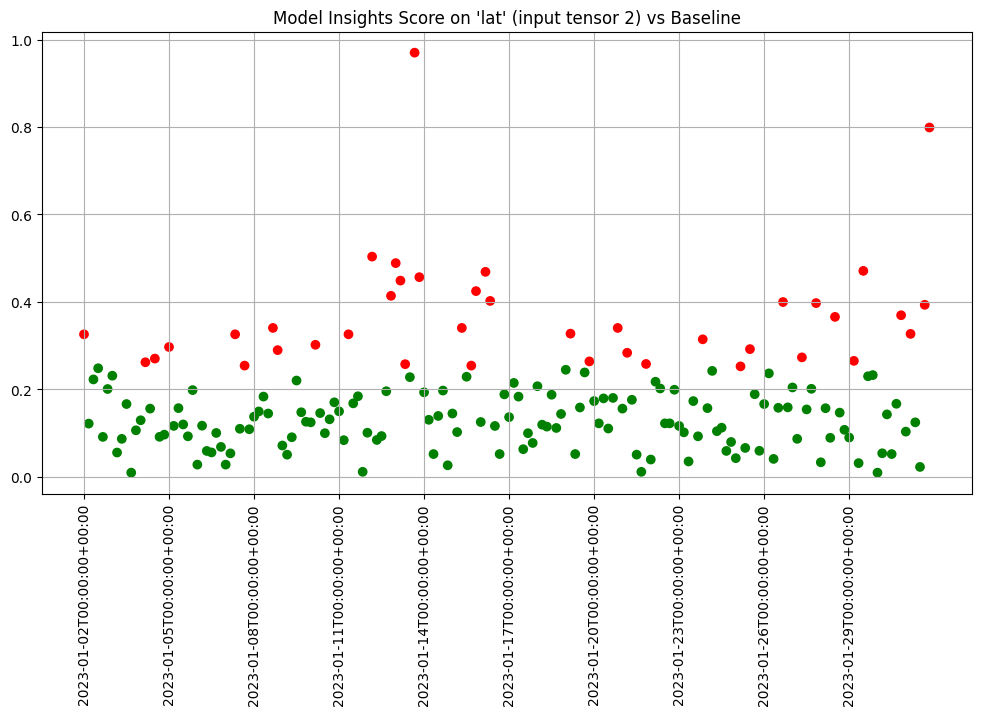

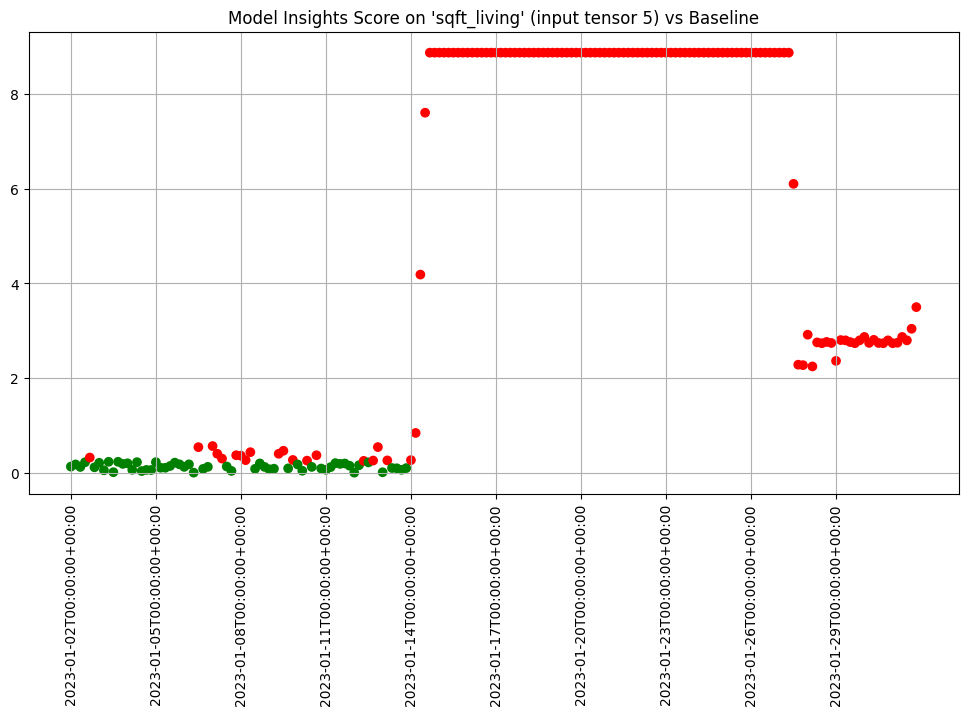

In [30]:
assay_results.chart_iopaths(labels=labels, selected_labels=['bedrooms', 'lat', 'sqft_living'])

When we are comfortable with what alert threshold should be for our specific purposes we can create and save an assay that will be automatically run on a daily basis.

In this example we're create an assay that runs everyday against the baseline and has an alert threshold of 0.5.

Once we upload it it will be saved and scheduled for future data as well as run against past data.

In [31]:
alert_threshold = 0.5
import string
import random


prefix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))

assay_name = f"{prefix}example assay"
assay_builder = wl.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end).add_alert_threshold(alert_threshold)
assay_id = assay_builder.upload()

After a short while, we can get the assay results for further analysis.

When we get the assay results, we see that the assays analysis is similar to the interactive run we started with though the analysis for the third day does not exceed the new alert threshold we set. And since we called `upload` instead of `interactive_run` the assay was saved to the system and will continue to run automatically on schedule from now on.

## Scheduling Assays

By default assays are scheduled to run every 24 hours starting immediately after the baseline period ends.

However, you can control the start time by setting `start` and the frequency by setting `interval` on the window.

So to recap:

* The window width is the size of the window. The default is 24 hours.
* The interval is how often the analysis is run, how far the window is slid into the future based on the last run. The default is the window width.
* The window start is when the analysis should start. The default is the end of the baseline period.

For example to run an analysis every 12 hours on the previous 24 hours of data you'd set the window width to 24 (the default) and the interval to 12.

In [32]:
assay_builder = wl.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end)
assay_builder = assay_builder.add_run_until(last_day)

assay_builder.window_builder().add_width(hours=24).add_interval(hours=12)

assay_config = assay_builder.build()

assay_results = assay_config.interactive_run()
print(f"Generated {len(assay_results)} analyses")

Generated 59 analyses


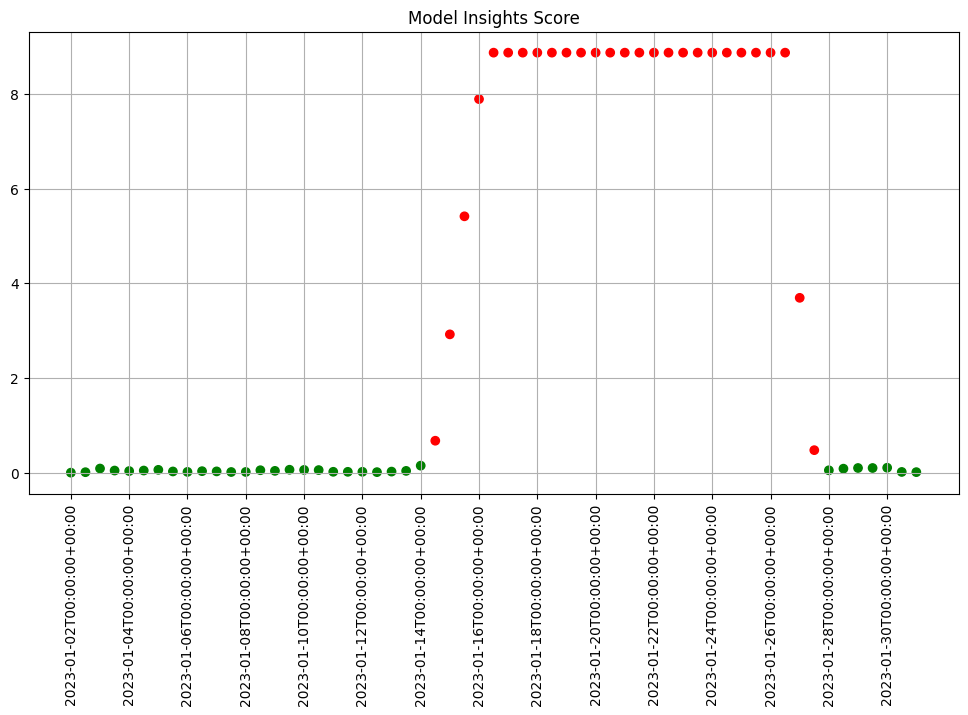

In [33]:
assay_results.chart_scores()

To start a weekly analysis of the previous week on a specific day, set the start date (taking care to specify the desired timezone), and the width and interval to 1 week and of course an analysis won't be generated till a window is complete.

In [34]:
report_start = datetime.datetime.fromisoformat('2022-01-03T00:00:00+00:00')

assay_builder = wl.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end)
assay_builder = assay_builder.add_run_until(last_day)

assay_builder.window_builder().add_width(weeks=1).add_interval(weeks=1).add_start(report_start)

assay_config = assay_builder.build()

assay_results = assay_config.interactive_run()
print(f"Generated {len(assay_results)} analyses")

Generated 5 analyses


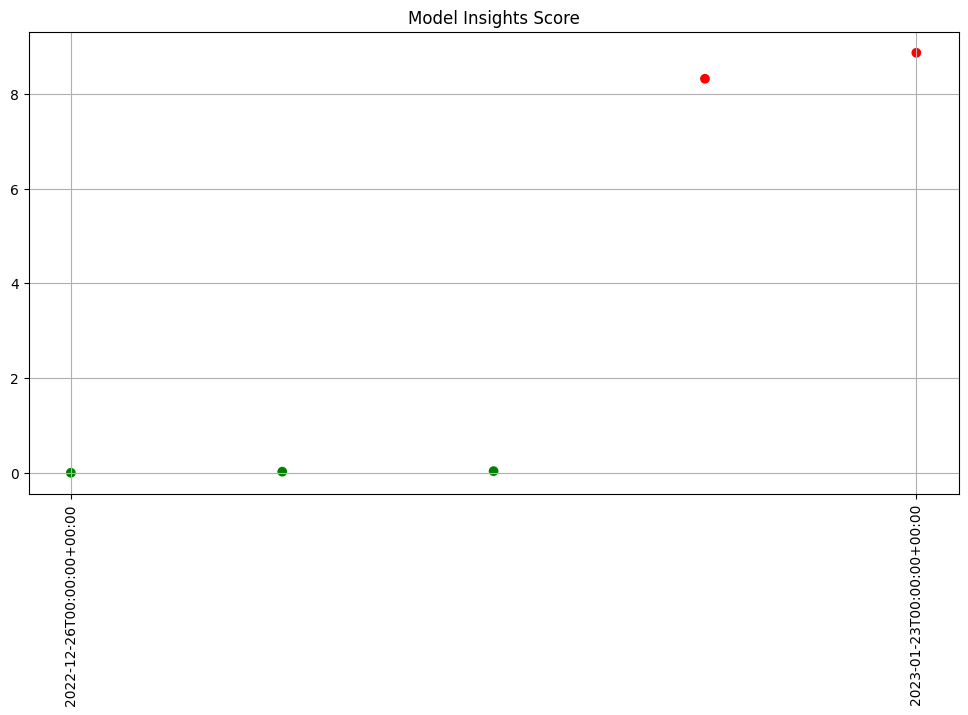

In [35]:
assay_results.chart_scores()

## Advanced Configuration

The assay can be configured in a variety of ways to help customize it to your particular needs. Specifically you can:
* change the BinMode to evenly spaced, quantile or user provided
* change the number of bins to use
* provide weights to use when scoring the bins
* calculate the score using the sum of differences, maximum difference or population stability index
* change the value aggregation for the bins to density, cumulative or edges

Lets take a look at these in turn.

### Default configuration

First lets look at the default configuration. This is a lot of information but much of it is useful to know where it is available.

We see that the assay is broken up into 4 sections. A top level meta data section, a section for the baseline specification, a section for the window specification and a section that specifies the summarization configuration.

In the meta section we see the name of the assay, that it runs on the first column of the first output `"outputs 0 0"` and that there is a default threshold of 0.25.

The summarizer section shows us the defaults of Quantile, Density and PSI on 5 bins.

The baseline section shows us that it is configured as a fixed baseline with the specified start and end date times.

And the window tells us what model in the pipeline we are analyzing and how often.

In [36]:
assay_builder = wl.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
print(assay_builder.build().to_json())

{
    "name": "lwkpexample assay",
    "pipeline_id": 4,
    "pipeline_name": "housepricepipe",
    "active": true,
    "status": "created",
    "iopath": "output dense_2 0",
    "baseline": {
        "Fixed": {
            "pipeline": "housepricepipe",
            "model": "housepricemodel",
            "start_at": "2023-01-01T00:00:00+00:00",
            "end_at": "2023-01-02T00:00:00+00:00"
        }
    },
    "window": {
        "pipeline": "housepricepipe",
        "model": "housepricemodel",
        "width": "24 hours",
        "start": null,
        "interval": null
    },
    "summarizer": {
        "type": "UnivariateContinuous",
        "bin_mode": "Quantile",
        "aggregation": "Density",
        "metric": "PSI",
        "num_bins": 5,
        "bin_weights": null,
        "bin_width": null,
        "provided_edges": null,
        "add_outlier_edges": true
    },
    "warning_threshold": null,
    "alert_threshold": 0.25,
    "run_until": "2023-02-01T00:00:00+00:00",
   

## Defaults

We can run the assay interactively and review the first analysis. The method `compare_basic_stats` gives us a dataframe with basic stats for the baseline and window data.

In [37]:
assay_results = assay_builder.build().interactive_run()
ar = assay_results[0]

ar.compare_basic_stats()

,Baseline,Window,diff,pct_diff
count,182.00,181.00,-1.00,-0.55
min,12.00,12.05,0.04,0.36
max,14.97,14.71,-0.26,-1.71
mean,12.94,12.97,0.03,0.22
median,12.88,12.90,0.01,0.12
std,0.45,0.48,0.03,5.68
start,2023-01-01T00:00:00+00:00,2023-01-02T00:00:00+00:00,NaN,NaN
end,2023-01-02T00:00:00+00:00,2023-01-03T00:00:00+00:00,NaN,NaN


The method `compare_bins` gives us a dataframe with the bin information. Such as the number of bins, the right edges, suggested bin/edge names and the values for each bin in the baseline and the window.

In [38]:
assay_bins = ar.compare_bins()
display(assay_bins.loc[:, assay_bins.columns!='w_aggregation'])

,b_edges,b_edge_names,b_aggregated_values,b_aggregation,w_edges,w_edge_names,w_aggregated_values,diff_in_pcts
0,12.00,left_outlier,0.00,Density,12.00,left_outlier,0.00,0.00
1,12.55,q_20,0.20,Density,12.55,e_1.26e1,0.19,-0.01
2,12.81,q_40,0.20,Density,12.81,e_1.28e1,0.21,0.01
3,12.98,q_60,0.20,Density,12.98,e_1.30e1,0.18,-0.02
4,13.33,q_80,0.20,Density,13.33,e_1.33e1,0.21,0.01
5,14.97,q_100,0.20,Density,14.97,e_1.50e1,0.21,0.01
6,NaN,right_outlier,0.00,Density,NaN,right_outlier,0.00,0.00


We can also plot the chart to visualize the values of the bins.

baseline mean = 12.940910643273655
window mean = 12.969964654406132
baseline median = 12.884286880493164
window median = 12.899214744567873
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.0029273068646199748
scores = [0.0, 0.000514261205558409, 0.0002139202456922972, 0.0012617897456473992, 0.0002139202456922972, 0.0007234154220295724, 0.0]
index = None


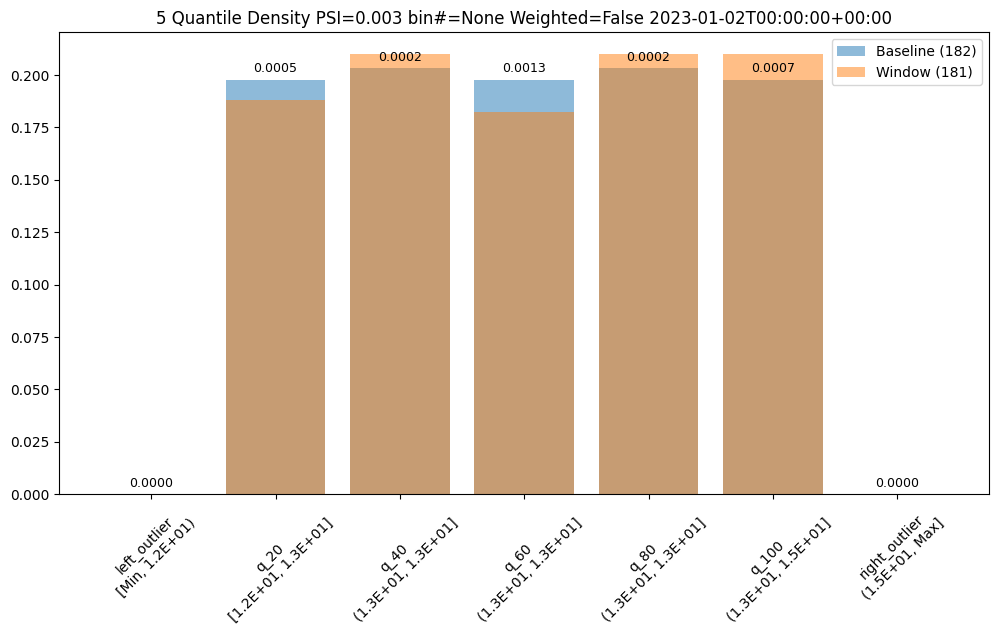

In [39]:
ar.chart()

## Binning Mode

We can change the bin mode algorithm to equal and see that the bins/edges are partitioned at different points and the bins have different values.

,b_edges,b_edge_names,b_aggregated_values,w_edges,w_edge_names,w_aggregated_values,diff_in_pcts
0,12.00,left_outlier,0.00,12.00,left_outlier,0.00,0.00
1,12.60,p_1.26e1,0.24,12.60,e_1.26e1,0.24,0.00
2,13.19,p_1.32e1,0.49,13.19,e_1.32e1,0.48,-0.02
3,13.78,p_1.38e1,0.22,13.78,e_1.38e1,0.22,-0.00
4,14.38,p_1.44e1,0.04,14.38,e_1.44e1,0.06,0.02
5,14.97,p_1.50e1,0.01,14.97,e_1.50e1,0.01,0.00
6,NaN,right_outlier,0.00,NaN,right_outlier,0.00,0.00


baseline mean = 12.940910643273655
window mean = 12.969964654406132
baseline median = 12.884286880493164
window median = 12.899214744567873
bin_mode = Equal
aggregation = Density
metric = PSI
weighted = False
score = 0.011074287819376092
scores = [0.0, 7.3591419975306595e-06, 0.000773779195360713, 8.538514991838585e-05, 0.010207597078872246, 1.6725322721660374e-07, 0.0]
index = None


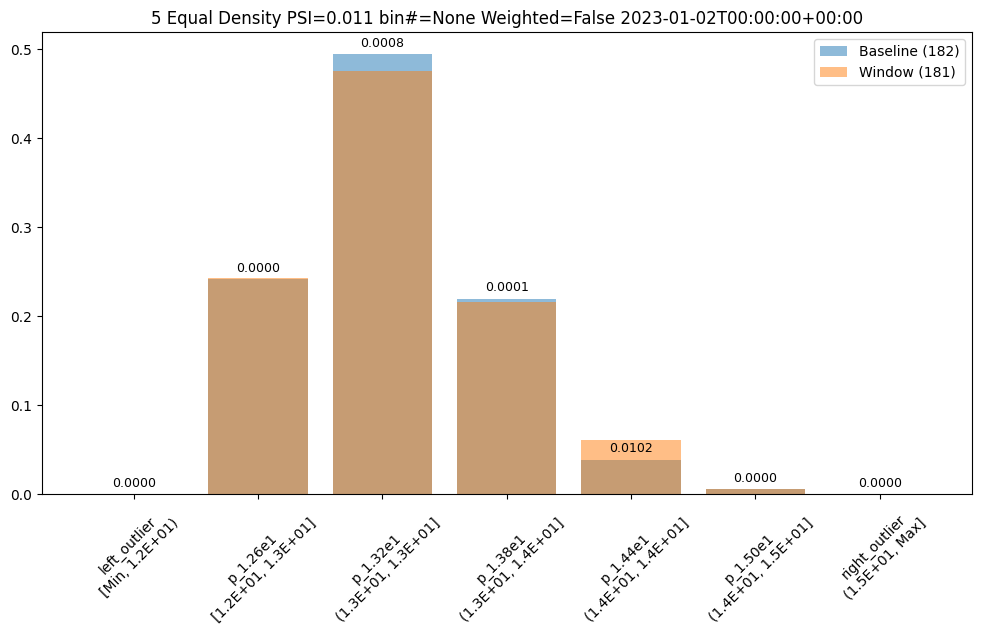

In [40]:
prefix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))

assay_name = f"{prefix}example assay"

assay_builder = wl.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_builder.summarizer_builder.add_bin_mode(BinMode.EQUAL)
assay_results = assay_builder.build().interactive_run()
assay_results_df = assay_results[0].compare_bins()
display(assay_results_df.loc[:, ~assay_results_df.columns.isin(['b_aggregation', 'w_aggregation'])])
assay_results[0].chart()

## User Provided Bin Edges

The values in this dataset run from ~11.6 to ~15.81. And lets say we had a business reason to use specific bin edges.  We can specify them with the BinMode.PROVIDED and specifying a list of floats with the right hand / upper edge of each bin and optionally the lower edge of the smallest bin. If the lowest edge is not specified the threshold for left outliers is taken from the smallest value in the baseline dataset.

,b_edges,b_edge_names,b_aggregated_values,w_edges,w_edge_names,w_aggregated_values,diff_in_pcts
0,11.00,left_outlier,0.00,11.00,left_outlier,0.00,0.00
1,12.00,e_1.20e1,0.00,12.00,e_1.20e1,0.00,0.00
2,13.00,e_1.30e1,0.62,13.00,e_1.30e1,0.59,-0.03
3,14.00,e_1.40e1,0.36,14.00,e_1.40e1,0.35,-0.00
4,15.00,e_1.50e1,0.02,15.00,e_1.50e1,0.06,0.03
5,16.00,e_1.60e1,0.00,16.00,e_1.60e1,0.00,0.00
6,NaN,right_outlier,0.00,NaN,right_outlier,0.00,0.00


baseline mean = 12.940910643273655
window mean = 12.969964654406132
baseline median = 12.884286880493164
window median = 12.899214744567873
bin_mode = Provided
aggregation = Density
metric = PSI
weighted = False
score = 0.0321620386600679
scores = [0.0, 0.0, 0.0014576920813015586, 3.549754401142936e-05, 0.030668849034754912, 0.0, 0.0]
index = None


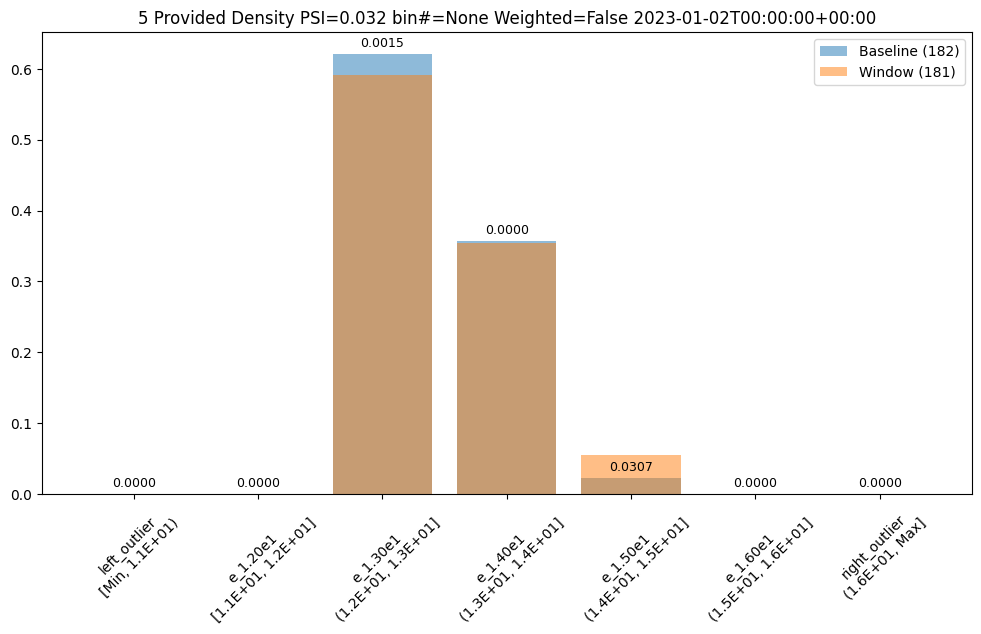

In [41]:
edges = [11.0, 12.0, 13.0, 14.0, 15.0, 16.0]
assay_builder = wl.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_builder.summarizer_builder.add_bin_mode(BinMode.PROVIDED, edges)
assay_results = assay_builder.build().interactive_run()
assay_results_df = assay_results[0].compare_bins()
display(assay_results_df.loc[:, ~assay_results_df.columns.isin(['b_aggregation', 'w_aggregation'])])
assay_results[0].chart()

## Number of Bins

We could also choose to a different number of bins, lets say 10, which can be evenly spaced or based on the quantiles (deciles).

,b_edges,b_edge_names,b_aggregated_values,w_edges,w_edge_names,w_aggregated_values,diff_in_pcts
0,12.00,left_outlier,0.00,12.00,left_outlier,0.00,0.00
1,12.41,q_10,0.10,12.41,e_1.24e1,0.09,-0.00
2,12.55,q_20,0.10,12.55,e_1.26e1,0.04,-0.05
3,12.72,q_30,0.10,12.72,e_1.27e1,0.14,0.03
4,12.81,q_40,0.10,12.81,e_1.28e1,0.05,-0.05
5,12.88,q_50,0.10,12.88,e_1.29e1,0.12,0.02
6,12.98,q_60,0.10,12.98,e_1.30e1,0.09,-0.01
7,13.15,q_70,0.10,13.15,e_1.32e1,0.18,0.08
8,13.33,q_80,0.10,13.33,e_1.33e1,0.14,0.03
9,13.47,q_90,0.10,13.47,e_1.35e1,0.07,-0.03


baseline mean = 12.940910643273655
window mean = 12.956829186961135
baseline median = 12.884286880493164
window median = 12.929338455200195
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.16591076620684958
scores = [0.0, 0.0002571306027792045, 0.044058279699182114, 0.009441459631493015, 0.03381618572319047, 0.0027335446937028877, 0.0011792419836838435, 0.051023062424253904, 0.009441459631493015, 0.008662563542113508, 0.0052978382749576496, 0.0]
index = None


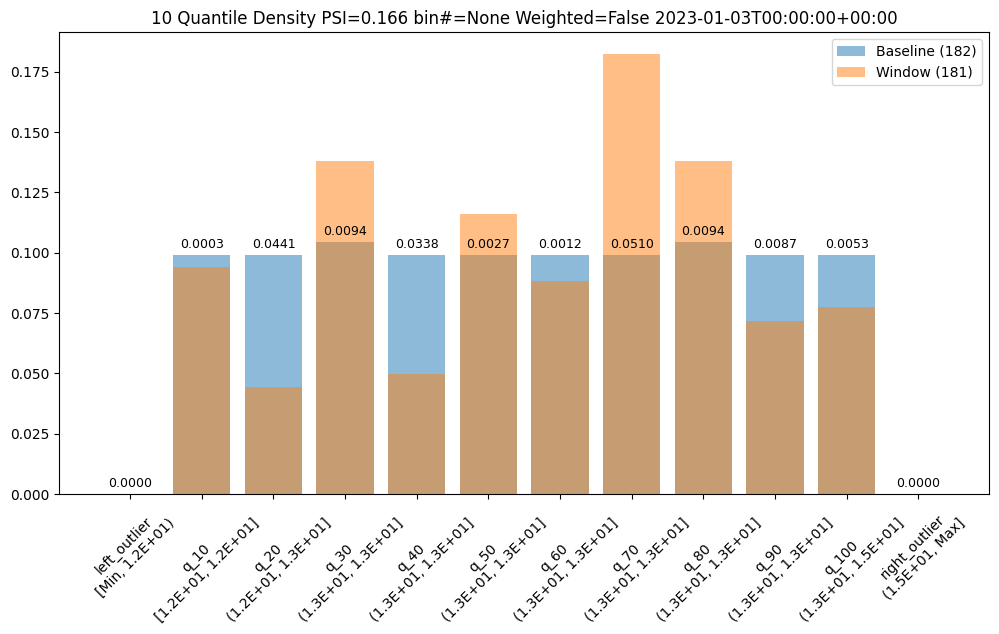

In [42]:
assay_builder = wl.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_builder.summarizer_builder.add_bin_mode(BinMode.QUANTILE).add_num_bins(10)
assay_results = assay_builder.build().interactive_run()
assay_results_df = assay_results[1].compare_bins()
display(assay_results_df.loc[:, ~assay_results_df.columns.isin(['b_aggregation', 'w_aggregation'])])
assay_results[1].chart()

## Bin Weights

Now lets say we only care about differences at the higher end of the range. We can use weights to specify that difference in the lower bins should not be counted in the score. 

If we stick with 10 bins we can provide 10 a vector of 12 weights. One weight each for the original bins plus one at the front for the left outlier bin and one at the end for the right outlier bin.

Note we still show the values for the bins but the scores for the lower 5 and left outlier are 0 and only the right half is counted and reflected in the score.

Using weights:  [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


,b_edges,b_edge_names,b_aggregated_values,w_edges,w_edge_names,w_aggregated_values,diff_in_pcts
0,12.00,left_outlier,0.00,12.00,left_outlier,0.00,0.00
1,12.41,q_10,0.10,12.41,e_1.24e1,0.09,-0.00
2,12.55,q_20,0.10,12.55,e_1.26e1,0.04,-0.05
3,12.72,q_30,0.10,12.72,e_1.27e1,0.14,0.03
4,12.81,q_40,0.10,12.81,e_1.28e1,0.05,-0.05
5,12.88,q_50,0.10,12.88,e_1.29e1,0.12,0.02
6,12.98,q_60,0.10,12.98,e_1.30e1,0.09,-0.01
7,13.15,q_70,0.10,13.15,e_1.32e1,0.18,0.08
8,13.33,q_80,0.10,13.33,e_1.33e1,0.14,0.03
9,13.47,q_90,0.10,13.47,e_1.35e1,0.07,-0.03


baseline mean = 12.940910643273655
window mean = 12.956829186961135
baseline median = 12.884286880493164
window median = 12.929338455200195
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = True
score = 0.012600694309416988
scores = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00019654033061397393, 0.00850384373737565, 0.0015735766052488358, 0.0014437605903522511, 0.000882973045826275, 0.0]
index = None


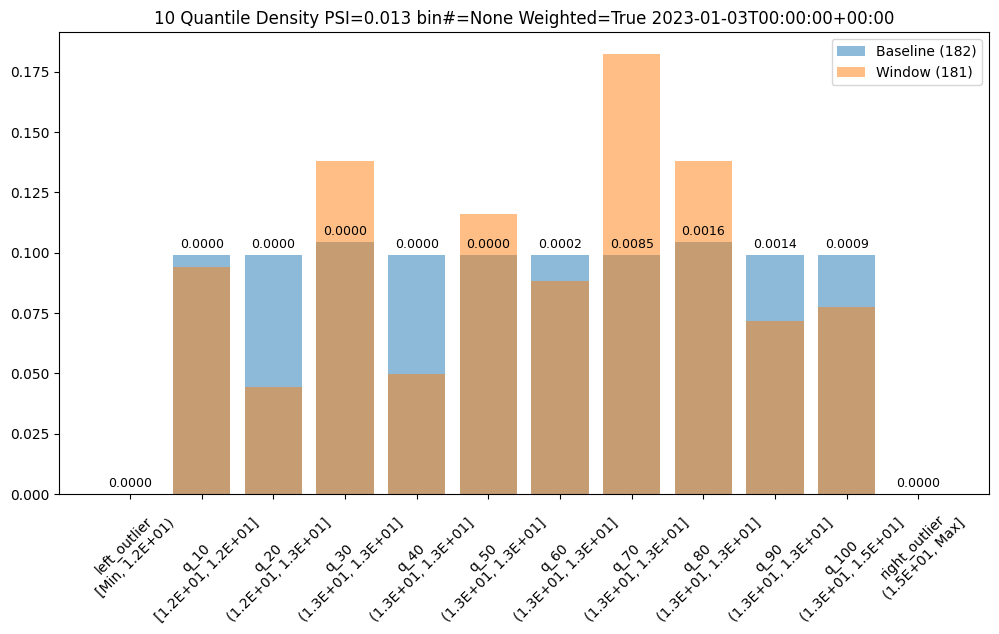

In [43]:
weights = [0] * 6
weights.extend([1] * 6)
print("Using weights: ", weights)
assay_builder = wl.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_builder.summarizer_builder.add_bin_mode(BinMode.QUANTILE).add_num_bins(10).add_bin_weights(weights)
assay_results = assay_builder.build().interactive_run()
assay_results_df = assay_results[1].compare_bins()
display(assay_results_df.loc[:, ~assay_results_df.columns.isin(['b_aggregation', 'w_aggregation'])])
assay_results[1].chart()

## Metrics

The `score` is a distance or dis-similarity measure. The larger it is the less similar the two distributions are. We currently support
summing the differences of each individual bin, taking the maximum difference and a modified Population Stability Index (PSI).

The following three charts use each of the metrics. Note how the scores change. The best one will depend on your particular use case.

baseline mean = 12.940910643273655
window mean = 12.969964654406132
baseline median = 12.884286880493164
window median = 12.899214744567873
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.0029273068646199748
scores = [0.0, 0.000514261205558409, 0.0002139202456922972, 0.0012617897456473992, 0.0002139202456922972, 0.0007234154220295724, 0.0]
index = None


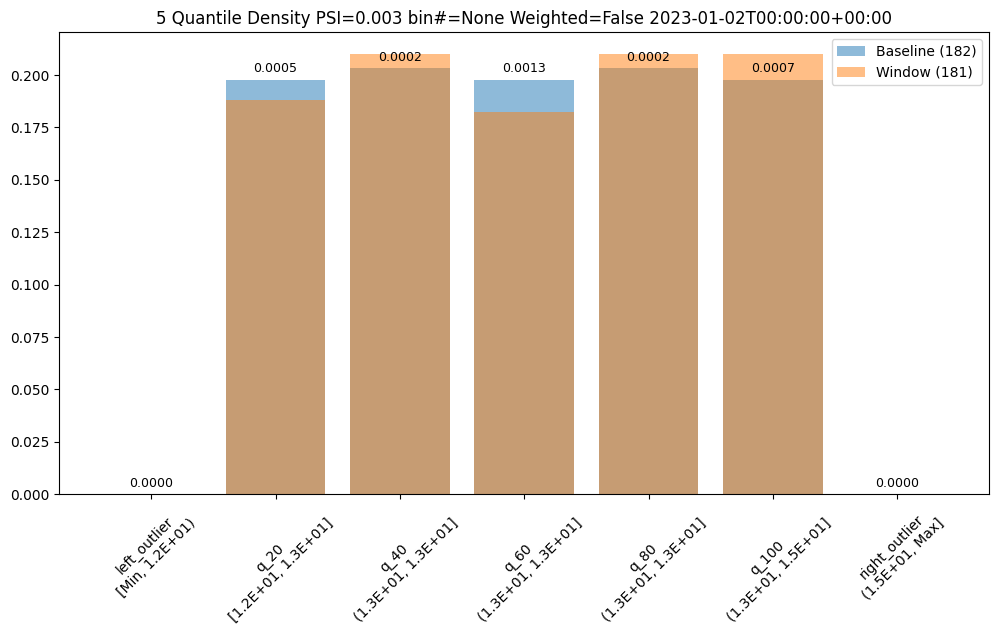

In [44]:
assay_builder = wl.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_results = assay_builder.build().interactive_run()
assay_results[0].chart()

baseline mean = 12.940910643273655
window mean = 12.969964654406132
baseline median = 12.884286880493164
window median = 12.899214744567873
bin_mode = Quantile
aggregation = Density
metric = SumDiff
weighted = False
score = 0.025438649748041997
scores = [0.0, 0.009956893934794486, 0.006648048084512165, 0.01548175581324751, 0.006648048084512165, 0.012142553579017668, 0.0]
index = None


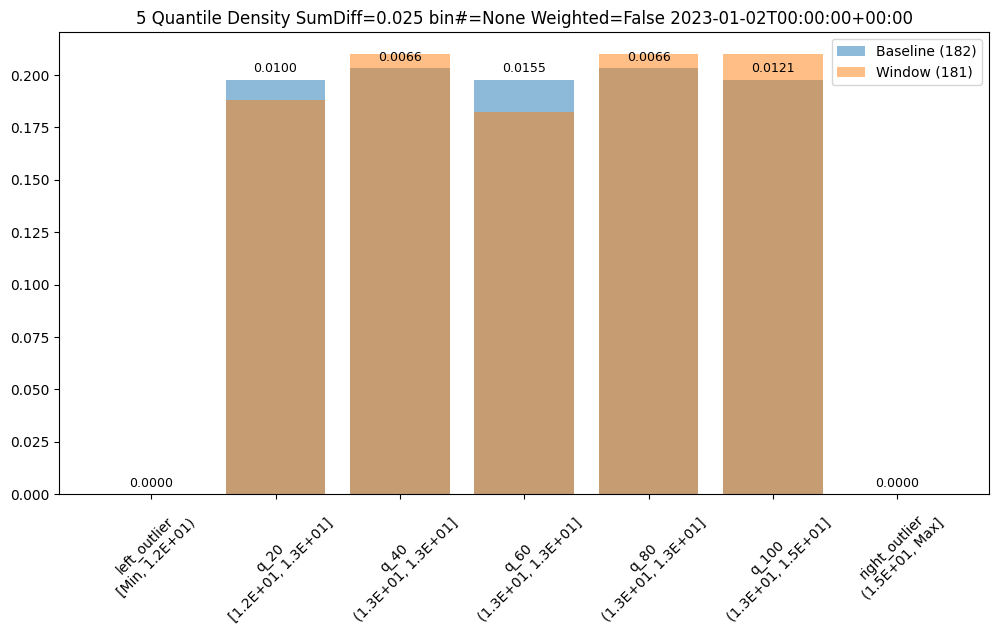

In [45]:
assay_builder = wl.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_builder.summarizer_builder.add_metric(Metric.SUMDIFF)
assay_results = assay_builder.build().interactive_run()
assay_results[0].chart()

baseline mean = 12.940910643273655
window mean = 12.969964654406132
baseline median = 12.884286880493164
window median = 12.899214744567873
bin_mode = Quantile
aggregation = Density
metric = MaxDiff
weighted = False
score = 0.01548175581324751
scores = [0.0, 0.009956893934794486, 0.006648048084512165, 0.01548175581324751, 0.006648048084512165, 0.012142553579017668, 0.0]
index = 3


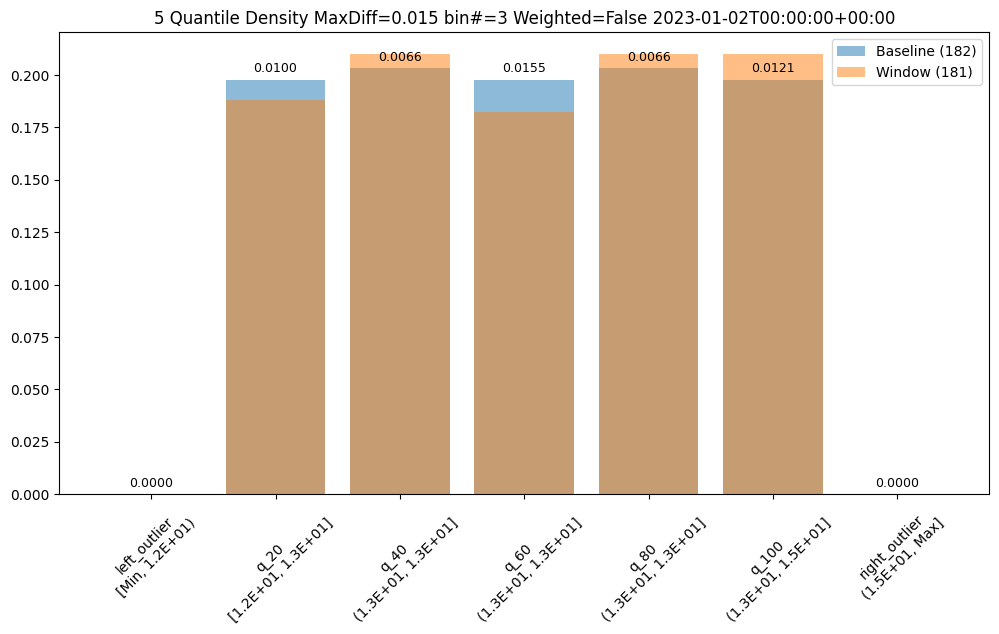

In [46]:
assay_builder = wl.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_builder.summarizer_builder.add_metric(Metric.MAXDIFF)
assay_results = assay_builder.build().interactive_run()
assay_results[0].chart()

## Aggregation Options

Also, bin aggregation can be done in histogram `Aggregation.DENSITY` style (the default) where we count the number/percentage of values that fall in each bin or Empirical Cumulative Density Function style `Aggregation.CUMULATIVE` where we keep a cumulative count of the values/percentages that fall in each bin.

baseline mean = 12.940910643273655
window mean = 12.969964654406132
baseline median = 12.884286880493164
window median = 12.899214744567873
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.0029273068646199748
scores = [0.0, 0.000514261205558409, 0.0002139202456922972, 0.0012617897456473992, 0.0002139202456922972, 0.0007234154220295724, 0.0]
index = None


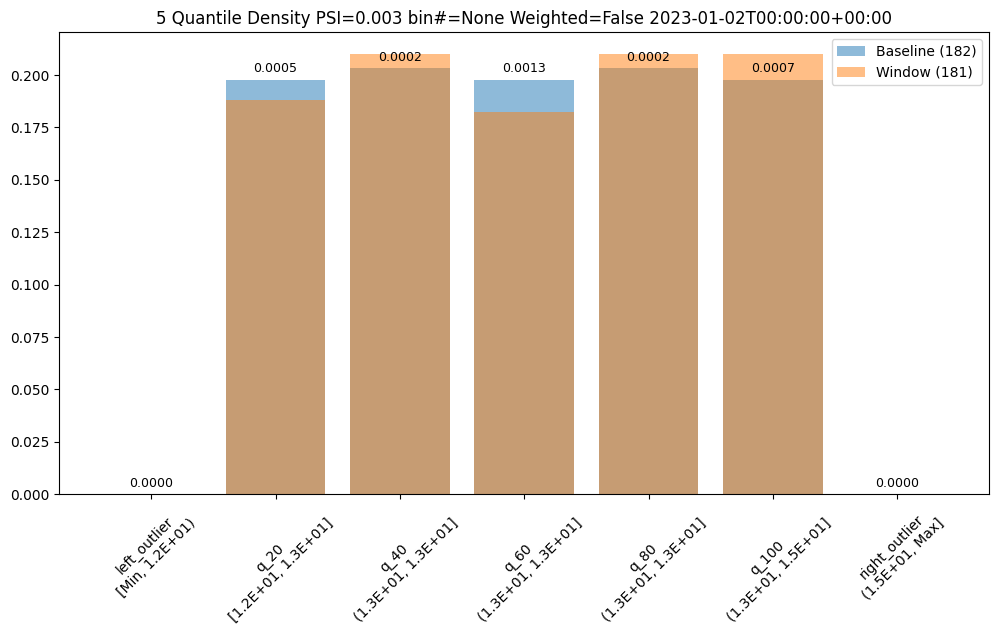

In [47]:
assay_builder = wl.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_builder.summarizer_builder.add_aggregation(Aggregation.DENSITY)
assay_results = assay_builder.build().interactive_run()
assay_results[0].chart()

baseline mean = 12.940910643273655
window mean = 12.969964654406132
baseline median = 12.884286880493164
window median = 12.899214744567873
bin_mode = Quantile
aggregation = Cumulative
metric = PSI
weighted = False
score = 0.04419889502762442
scores = [0.0, 0.009956893934794486, 0.0033088458502823492, 0.01879060166352986, 0.012142553579017725, 0.0, 0.0]
index = None


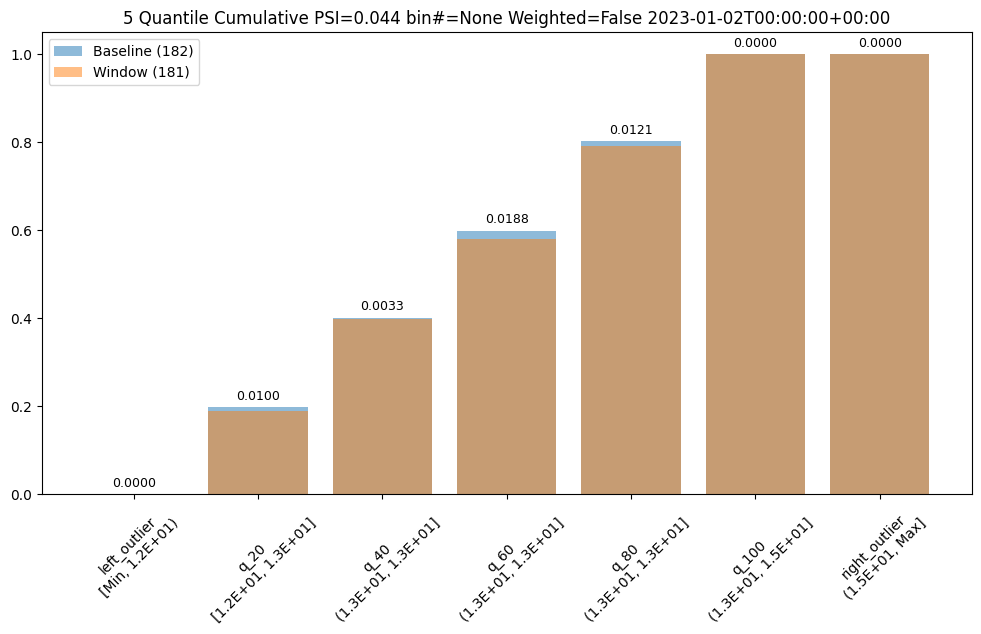

In [48]:
assay_builder = wl.build_assay(assay_name, pipeline, model_name, baseline_start, baseline_end).add_run_until(last_day)
assay_builder.summarizer_builder.add_aggregation(Aggregation.CUMULATIVE)
assay_results = assay_builder.build().interactive_run()
assay_results[0].chart()